In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from collections import OrderedDict
from tqdm import tqdm

sns.set_style("white")

In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [11]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        self.h = 0.01
        self.k = 0.01
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)
        #print("x: ", x.shape, "t: ", t.shape)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        #print("X",self.X.shape)
        
        # training data
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        #print("X_train",self.X_train.shape)
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = torch.sin(math.pi * ic[:, 0])
        #print("y_bc1: ", y_bc1.shape, "y_bc2: ", y_bc2.shape, "y_ic: ", y_ic.shape)
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())

    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        y = self.model(self.X)
        
        x = self.X[:,0]
        t = self.X[:,1]
        #print("Inside x: ", x.shape, "t: ", t.shape)
        dy_dX = torch.autograd.grad(inputs=self.X, outputs=y, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
        #print("dy_dX: ", dy_dX.shape)
        dy_dx = dy_dX[:, 0]
        #print("dy_dx: ", dy_dx.shape)
        dy_dt = dy_dX[:, 1]
        #print("dy_dt; ", dy_dt.shape)
        dy_dxx = torch.autograd.grad(inputs=self.X, outputs=dy_dX, grad_outputs=torch.ones_like(dy_dX), retain_graph=True, create_graph=True)[0][:, 0]
        #print("dy_dxx: ", dy_dxx.shape)
        loss_pde = self.criterion(dy_dt - dy_dxx, (torch.exp(-t))*(torch.sin(math.pi * x) - (math.pi)*(math.pi)*torch.sin(math.pi * x)))

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        for i in range(10000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

In [12]:
net = Net()
net.train()

100 3.263822078704834
200 0.8983402848243713
300 0.41382062435150146
400 0.2538406252861023
500 0.17225974798202515
600 0.104220449924469
700 0.06497078388929367
800 0.048596881330013275
900 0.039545975625514984
1000 0.03220868855714798
1100 0.025704016909003258
1200 0.020564790815114975
1300 0.017263583838939667
1400 0.015137318521738052
1500 0.013510951772332191
1600 0.012163564562797546
1700 0.010790126398205757
1800 0.009600838646292686
1900 0.008431627415120602
2000 0.007341641467064619
2100 0.006418135948479176
2200 0.005601162556558847
2300 0.004956951830536127
2400 0.00445863651111722
2500 0.004064074717462063
2600 0.0039289528504014015
2700 0.003542009275406599
2800 0.003356434404850006
2900 0.003246275708079338
3000 0.003084351774305105
3100 0.0030503461603075266
3200 0.002885649213567376
3300 0.002802497474476695
3400 0.0031319614499807358
3500 0.0026582530699670315
3600 0.002592433011159301
3700 0.003388762939721346
3800 0.00247087306343019
3900 0.002413424663245678
4000 0.

In [13]:
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [14]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

<AxesSubplot:>

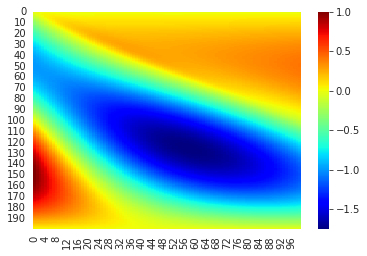

In [15]:
sns.heatmap(y_pred, cmap='jet')

In [16]:
mat = {'v': y_pred}
scipy.io.savemat('diffusion_pinn_2.mat', mat)